In [70]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

In [71]:
df = pd.read_csv('hepatitis.data', usecols=[0, 1, 8, 9, 14, 15, 16, 17, 18],
                 names=['CLASS', 'AGE', 'LIVER BIG', 'LIVER FIRM', 'BILIRUBIN',
                        'ALK PHOSPHATE', 'SGOT', 'ALBUMIN', 'PROTIME'])

прочитали данные, и добавили названия колонок, поскольку в файле нет заголовка

In [69]:
import pandas_profiling
df.profile_report()

In [72]:
df = df.replace(to_replace='?', value=np.nan)

заменили значения '?' на NaN, чтоб pandas регистрировал их ка пропущеные данные

In [73]:
df = df.astype('float64')

изменили тип на числовой, потому как он был object за счет смешаных числовых типов и значений '?'

для того чтобы как-то решить проблему с пропущеными данными, заполним их средним в трех колонках с большим количеством пропущеных, а остальные просто выкинем (в остальных числовых колонках мало пропущеных, а заменять средним в категориальных нельзя)

In [74]:
df[['ALK PHOSPHATE', 'ALBUMIN', 'PROTIME']] = \
df[['ALK PHOSPHATE', 'ALBUMIN', 'PROTIME']].fillna(df[['ALK PHOSPHATE', 'ALBUMIN', 'PROTIME']].mean())

In [75]:
df.dropna(inplace=True)

прежде чем использовать наивный байес, посмотрим на зависимости наших переменных

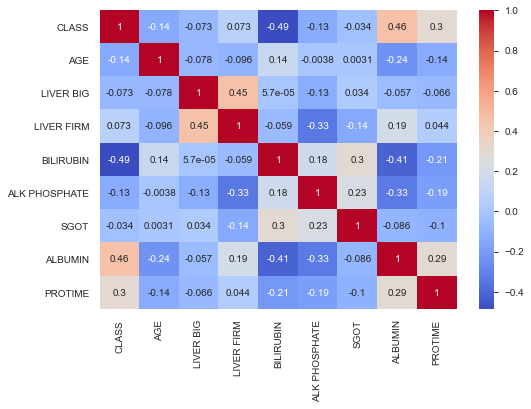

In [78]:
sns.heatmap(df.corr(), cmap='coolwarm', annot=True)

кореляции между предикторами почти нет, что очень важно для байеса,  
поскольку он работает на предположении о независимых предикторах

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, [1, 4, 5, 6, 7, 8]],
                                                    df[['CLASS']], test_size=0.2, random_state=42)

In [10]:
gnb = GaussianNB()
gnb.fit(X_train, y_train.values.ravel())
y_pred = gnb.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred, pos_label=2)}')
print(f'Recall: {recall_score(y_test, y_pred, pos_label=2)}')
print(f'F1 Score: {f1_score(y_test, y_pred, pos_label=2)}')

Accuracy: 0.7142857142857143
Precision: 0.7777777777777778
Recall: 0.7777777777777778
F1 Score: 0.7777777777777778


модель угадывает в 71% случаев, и остальные статистики тоже более-менее неплохие

In [11]:
knn_search = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': [1, 3, 5, 10]})
knn_search.fit(X_train, y_train.values.ravel())
knn = knn_search.best_estimator_
knn_search.best_params_

{'n_neighbors': 3}

использовав gridsearch, нашли подходящий параметр k = 3

In [13]:
y_pred = knn.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred, pos_label=2)}')
print(f'Recall: {recall_score(y_test, y_pred, pos_label=2)}')
print(f'F1 Score: {f1_score(y_test, y_pred, pos_label=2)}')

Accuracy: 0.5714285714285714
Precision: 0.6153846153846154
Recall: 0.8888888888888888
F1 Score: 0.7272727272727274


результат в целом хуже, хотя чувствительность (recall) стала больше.  
Это говорит о том, что модель стала угадывать больше позитивных исходов,  
что безусловно важно в нашей модели

In [16]:
logit = LogisticRegression()
logit.fit(X_train, y_train.values.ravel())
y_pred = logit.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred, pos_label=2)}')
print(f'Recall: {recall_score(y_test, y_pred, pos_label=2)}')
print(f'F1 Score: {f1_score(y_test, y_pred, pos_label=2)}')

Accuracy: 0.6071428571428571
Precision: 0.6842105263157895
Recall: 0.7222222222222222
F1 Score: 0.7027027027027027


применив логистическую регрессию, получили результат хуже,  
но accuracy и recall все же выше,чем у knn

теперь попробуем добавить факторную переменную

In [17]:
df.loc[(df['LIVER BIG'] == 1) & (df['LIVER FIRM'] == 1), 'FACTOR'] = 1
df.loc[(df['LIVER BIG'] == 1) & (df['LIVER FIRM'] == 2), 'FACTOR'] = 2
df.loc[(df['LIVER BIG'] == 2) & (df['LIVER FIRM'] == 1), 'FACTOR'] = 3
df.loc[(df['LIVER BIG'] == 2) & (df['LIVER FIRM'] == 2), 'FACTOR'] = 4
df = df.drop(columns=['LIVER BIG', 'LIVER FIRM'])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 1:], df[['CLASS']],
                                                    test_size=0.2, random_state=42)

In [20]:
gnb = GaussianNB()
gnb.fit(X_train, y_train.values.ravel())
y_pred = gnb.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred, pos_label=2)}')
print(f'Recall: {recall_score(y_test, y_pred, pos_label=2)}')
print(f'F1 Score: {f1_score(y_test, y_pred, pos_label=2)}')

Accuracy: 0.7142857142857143
Precision: 0.7777777777777778
Recall: 0.7777777777777778
F1 Score: 0.7777777777777778


результат такой же, как и без фактора

In [21]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train.values.ravel())
y_pred = knn.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred, pos_label=2)}')
print(f'Recall: {recall_score(y_test, y_pred, pos_label=2)}')
print(f'F1 Score: {f1_score(y_test, y_pred, pos_label=2)}')

Accuracy: 0.5714285714285714
Precision: 0.6153846153846154
Recall: 0.8888888888888888
F1 Score: 0.7272727272727274


тут тоже

In [26]:
logit = LogisticRegression()
logit.fit(X_train, y_train.values.ravel())
y_pred = logit.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred, pos_label=2)}')
print(f'Recall: {recall_score(y_test, y_pred, pos_label=2)}')
print(f'F1 Score: {f1_score(y_test, y_pred, pos_label=2)}')

Accuracy: 0.6428571428571429
Precision: 0.7222222222222222
Recall: 0.7222222222222222
F1 Score: 0.7222222222222222


/home/andrey/PycharmProjects/julia_lab/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


тут получили accuracy и precision чуть выше, чем без фактора

теперь попробуем отдельные выборки по фактору

In [38]:
df_1 = df.loc[df['FACTOR'] == 1].drop('FACTOR', axis=1)
df_2 = df.loc[df['FACTOR'] == 2].drop('FACTOR', axis=1)
df_3 = df.loc[df['FACTOR'] == 3].drop('FACTOR', axis=1)
df_4 = df.loc[df['FACTOR'] == 4].drop('FACTOR', axis=1)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(df_1.iloc[:, 1:], df_1[['CLASS']],
                                                    test_size=0.2, random_state=42)

In [49]:
gnb = GaussianNB()
gnb.fit(X_train, y_train.values.ravel())
y_pred = gnb.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred, pos_label=2)}')
print(f'Recall: {recall_score(y_test, y_pred, pos_label=2)}')
print(f'F1 Score: {f1_score(y_test, y_pred, pos_label=2)}')

Accuracy: 0.8
Precision: 0.8
Recall: 1.0
F1 Score: 0.888888888888889


In [50]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train.values.ravel())
y_pred = knn.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred, pos_label=2)}')
print(f'Recall: {recall_score(y_test, y_pred, pos_label=2)}')
print(f'F1 Score: {f1_score(y_test, y_pred, pos_label=2)}')

Accuracy: 0.8
Precision: 0.8
Recall: 1.0
F1 Score: 0.888888888888889


In [51]:
logit = LogisticRegression()
logit.fit(X_train, y_train.values.ravel())
y_pred = logit.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred, pos_label=2)}')
print(f'Recall: {recall_score(y_test, y_pred, pos_label=2)}')
print(f'F1 Score: {f1_score(y_test, y_pred, pos_label=2)}')

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


результат по первой выборке впечатляет

In [57]:
df_2

,CLASS,AGE,BILIRUBIN,ALK PHOSPHATE,SGOT,ALBUMIN,PROTIME
0,2.0,30.0,1.0,85.0,18.0,4.0,61.852273
1,2.0,50.0,0.9,135.0,42.0,3.5,61.852273


вторая выборка имеет всего два образца, поэтому особого анализа мы провести не можем

In [52]:
X_train, X_test, y_train, y_test = train_test_split(df_2.iloc[:, 1:], df_2[['CLASS']],
                                                    test_size=0.2, random_state=42)

In [53]:
gnb = GaussianNB()
gnb.fit(X_train, y_train.values.ravel())
y_pred = gnb.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred, pos_label=2)}')
print(f'Recall: {recall_score(y_test, y_pred, pos_label=2)}')
print(f'F1 Score: {f1_score(y_test, y_pred, pos_label=2)}')

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


/home/andrey/PycharmProjects/julia_lab/venv/lib/python3.8/site-packages/sklearn/naive_bayes.py:450: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
/home/andrey/PycharmProjects/julia_lab/venv/lib/python3.8/site-packages/sklearn/naive_bayes.py:451: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
/home/andrey/PycharmProjects/julia_lab/venv/lib/python3.8/site-packages/sklearn/naive_bayes.py:451: RuntimeWarning: invalid value encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /


In [58]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train.values.ravel())
y_pred = knn.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred, pos_label=2)}')
print(f'Recall: {recall_score(y_test, y_pred, pos_label=2)}')
print(f'F1 Score: {f1_score(y_test, y_pred, pos_label=2)}')

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [55]:
logit = LogisticRegression()
logit.fit(X_train, y_train.values.ravel())
y_pred = logit.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred, pos_label=2)}')
print(f'Recall: {recall_score(y_test, y_pred, pos_label=2)}')
print(f'F1 Score: {f1_score(y_test, y_pred, pos_label=2)}')

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 2.0

In [59]:
X_train, X_test, y_train, y_test = train_test_split(df_3.iloc[:, 1:], df_3[['CLASS']],
                                                    test_size=0.2, random_state=42)

In [60]:
gnb = GaussianNB()
gnb.fit(X_train, y_train.values.ravel())
y_pred = gnb.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred, pos_label=2)}')
print(f'Recall: {recall_score(y_test, y_pred, pos_label=2)}')
print(f'F1 Score: {f1_score(y_test, y_pred, pos_label=2)}')

Accuracy: 0.875
Precision: 1.0
Recall: 0.8333333333333334
F1 Score: 0.9090909090909091


In [61]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train.values.ravel())
y_pred = knn.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred, pos_label=2)}')
print(f'Recall: {recall_score(y_test, y_pred, pos_label=2)}')
print(f'F1 Score: {f1_score(y_test, y_pred, pos_label=2)}')

Accuracy: 0.5
Precision: 0.6666666666666666
Recall: 0.6666666666666666
F1 Score: 0.6666666666666666


In [62]:
logit = LogisticRegression()
logit.fit(X_train, y_train.values.ravel())
y_pred = logit.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred, pos_label=2)}')
print(f'Recall: {recall_score(y_test, y_pred, pos_label=2)}')
print(f'F1 Score: {f1_score(y_test, y_pred, pos_label=2)}')

Accuracy: 0.625
Precision: 0.8
Recall: 0.6666666666666666
F1 Score: 0.7272727272727272


по третьей выборке имеем результаты похуже, чем по первой,  
хотя наивный байес показывает лучший результат, чем без учета фактора,  
а лог рег имеет больший precision

In [64]:
X_train, X_test, y_train, y_test = train_test_split(df_4.iloc[:, 1:], df_4[['CLASS']],
                                                    test_size=0.2, random_state=42)

In [65]:
gnb = GaussianNB()
gnb.fit(X_train, y_train.values.ravel())
y_pred = gnb.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred, pos_label=2)}')
print(f'Recall: {recall_score(y_test, y_pred, pos_label=2)}')
print(f'F1 Score: {f1_score(y_test, y_pred, pos_label=2)}')

Accuracy: 0.875
Precision: 0.8666666666666667
Recall: 1.0
F1 Score: 0.9285714285714286


In [66]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train.values.ravel())
y_pred = knn.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred, pos_label=2)}')
print(f'Recall: {recall_score(y_test, y_pred, pos_label=2)}')
print(f'F1 Score: {f1_score(y_test, y_pred, pos_label=2)}')

Accuracy: 0.8125
Precision: 0.8125
Recall: 1.0
F1 Score: 0.896551724137931


In [67]:
logit = LogisticRegression()
logit.fit(X_train, y_train.values.ravel())
y_pred = logit.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred, pos_label=2)}')
print(f'Recall: {recall_score(y_test, y_pred, pos_label=2)}')
print(f'F1 Score: {f1_score(y_test, y_pred, pos_label=2)}')

Accuracy: 0.8125
Precision: 0.8125
Recall: 1.0
F1 Score: 0.896551724137931


тут тоже неплохо, и отметим, что везде recall = 1, а это для нас самая важная оценка